## MICE
Utiliser MICE (Multiple Imputation by Chained Equations)  pour imputer les valeurs manquante.  

**Objectif** :  
* Vérifier si les conditions d'une bonne convergence sont respectées
* Utiliser **MICE**pour imputer les valeurs manquantes.
* Comparer les distributions avant et après imputation
* Comparer les éléments statistiques avant et après imputation

  
Vous pouvez trouver la documentation ici [MICE](https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICE.html).s

### Librairies & warnings contrôle

In [1]:
import pandas as pd
import numpy as np
from statsmodels.imputation import mice
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import missingno as misno

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Fonction pour la visualisation avant et après l'imputation

In [3]:
def ajust_graph():
    plt.subplots_adjust(left=0,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)

In [4]:
def plot_dist(data, color = 'none', n_col = 3, n_rows = 2) :
    
    """Permet d'afficher des distributions
    de plusieurs variables numeriques
    avec une bonne mise en forme"""
    
    df_numeric = data.select_dtypes(include =['float', 'int'])
    for i, col in tqdm(enumerate(df_numeric)):
        plt.subplot(n_rows, n_col, i+1)
        ajust_graph()
        sns.distplot(df_numeric[col], color = color, hist = False, label = f"{col}" if color == 'red' else f"{col}_imputed" )
        plt.title(f"{col}\n(Taux de nan : {taux_nan[col]:.2f}%)", fontsize =12)
        plt.legend(loc = 'best')
        plt.xlabel('variable')
        plt.grid(True)
    #plt.tight_layout()

### Chargement et lecture du dataset

In [5]:
use_cols = ['VILLE', 'NOMBRE_ETUDIANTS', 'AGE_ENTREE', 
 'COUT_MOYEN_ANNEE_ACADEMIE', 'TAUX_ADMISSION', "DEFAUT_PAIEMENT_2ANNEES",
           'DEFAUT_PAIEMENT_3ANNEES']


In [6]:
df = pd.read_csv("data.csv", usecols = use_cols).sample(n = 300,random_state =0)

In [7]:
df. head(3)

,VILLE,NOMBRE_ETUDIANTS,AGE_ENTREE,COUT_MOYEN_ANNEE_ACADEMIE,TAUX_ADMISSION,DEFAUT_PAIEMENT_2ANNEES,DEFAUT_PAIEMENT_3ANNEES
6747,Houston,13484,33.360801106,NaN,NaN,0.105,0.104
3687,Beckley,5340,20.54234904,17166.0,0.6065,0.086,0.080
5625,Santa Fe Springs,37,28.626666667,NaN,NaN,0.000,0.190


In [8]:
df.rename(columns=str.lower, inplace=True)

In [9]:
df.shape

(300, 7)

In [10]:
((df.isna().sum()/ df.shape[0])*100).sort_values()

ville                         0.000000
nombre_etudiants              4.666667
age_entree                    7.333333
defaut_paiement_3annees      18.000000
defaut_paiement_2annees      19.333333
cout_moyen_annee_academie    52.333333
taux_admission               72.000000
dtype: float64

In [11]:
taux_nan= df.isna().mean()*100

### Vérification de linéarité ou non-linéarité

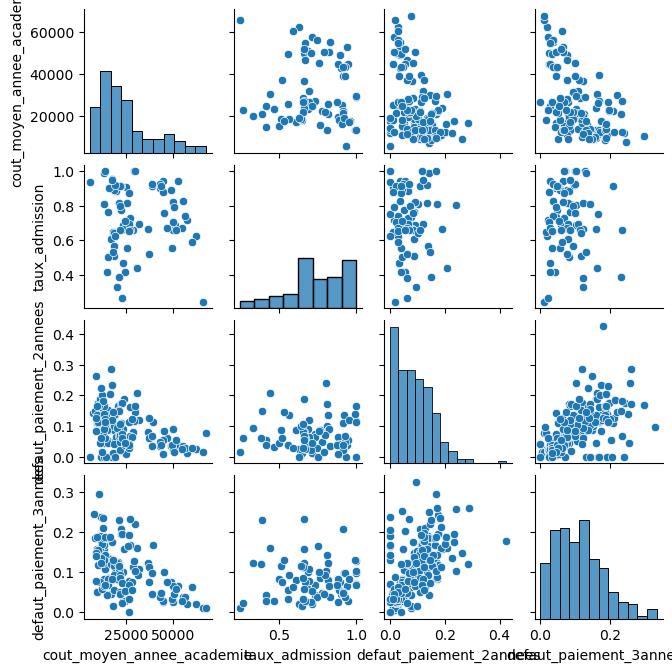

In [12]:
sns.pairplot(df, height = 1.7)

#### Commentaire

* Nos variables ne sont ni fortement linéaires (i.e les points ne suivent pas la première bissectrice) ni fortement non-linéaire (genre les points ne suivent pas une fonction sinusoidale).

* Parmi nos variables, il y'a 2 dont le taux de valeurs manquantes est très élevé ( plus de 50% ).

* Nous allons donc appliquer le fameux  MICE pour imputer les nan et tirer une conclusion sur le niveau de précision.

### Imputation avec MICE

In [13]:
df.dtypes

ville                         object
nombre_etudiants              object
age_entree                    object
cout_moyen_annee_academie    float64
taux_admission               float64
defaut_paiement_2annees      float64
defaut_paiement_3annees      float64
dtype: object

In [14]:
df.loc[df["age_entree"]=='PrivacySuppressed', :]

,ville,nombre_etudiants,age_entree,cout_moyen_annee_academie,taux_admission,defaut_paiement_2annees,defaut_paiement_3annees
202,San Francisco,PrivacySuppressed,PrivacySuppressed,NaN,NaN,0.009,0.010
3287,Houston,PrivacySuppressed,PrivacySuppressed,NaN,NaN,0.016,0.005
5467,Kailua Kona,PrivacySuppressed,PrivacySuppressed,NaN,1.0,NaN,NaN
3225,Nashville,PrivacySuppressed,PrivacySuppressed,NaN,NaN,0.033,0.024
5047,Denver,PrivacySuppressed,PrivacySuppressed,NaN,NaN,0.000,0.142
4542,Wadesboro,PrivacySuppressed,PrivacySuppressed,NaN,NaN,NaN,NaN
311,Berkeley,NaN,PrivacySuppressed,NaN,NaN,0.030,0.050
296,Santa Cruz,PrivacySuppressed,PrivacySuppressed,NaN,NaN,0.011,0.032


**Commentaire**:

On va transformer ces lignes en nan

In [15]:
# la colonne contient une valeur string ce qui empêche la conversion en entier
df.loc[df['nombre_etudiants'] == 'PrivacySuppressed', 'nombre_etudiants'] = np.nan
df.loc[df['age_entree'] == 'PrivacySuppressed', 'age_entree'] = np.nan
#convertir ces varaible en float
df['nombre_etudiants'] = pd.to_numeric(df['nombre_etudiants'])
df['age_entree'] = np.round(pd.to_numeric(df['age_entree']), 2)

In [16]:
df.dtypes

ville                         object
nombre_etudiants             float64
age_entree                   float64
cout_moyen_annee_academie    float64
taux_admission               float64
defaut_paiement_2annees      float64
defaut_paiement_3annees      float64
dtype: object

In [17]:
((df.isna().sum()/ df.shape[0])*100).sort_values()

ville                         0.000000
age_entree                   10.000000
nombre_etudiants             12.333333
defaut_paiement_3annees      18.000000
defaut_paiement_2annees      19.333333
cout_moyen_annee_academie    52.333333
taux_admission               72.000000
dtype: float64

In [18]:
df_num = df.select_dtypes(include =['float'])

In [19]:
imputer = mice.MICEData(df_num)
imputed_data = imputer.data

In [20]:
imputed_data.head(2)

,nombre_etudiants,age_entree,cout_moyen_annee_academie,taux_admission,defaut_paiement_2annees,defaut_paiement_3annees
0,13484.0,33.36,24836.0,0.7347,0.105,0.104
1,5340.0,20.54,17166.0,0.6065,0.086,0.080


In [21]:
imputed_data.isna().sum()

nombre_etudiants             0
age_entree                   0
cout_moyen_annee_academie    0
taux_admission               0
defaut_paiement_2annees      0
defaut_paiement_3annees      0
dtype: int64

### Visualisation avant et après imputation

6it [00:00,  8.56it/s]
6it [00:00, 25.47it/s]


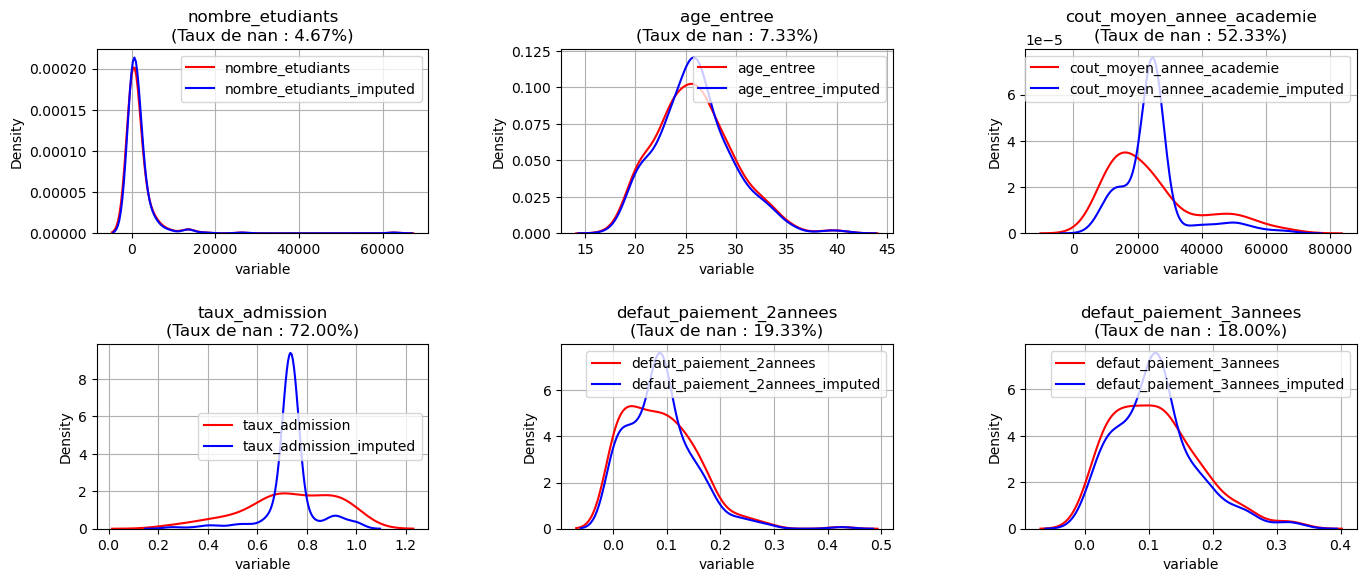

In [22]:
plt.figure(figsize=(14, 6))
plot_dist(df, color = 'red', n_col = 3 , n_rows =2 )
plot_dist(imputed_data, color = 'blue',  n_col = 3 , n_rows =2)

**Commentaire** :
  
* Vous voyez à quel point cette methode est puissante, plus le taux le valeurs manquantes est faible, plus l'estimation est précise. C'est incroyable.


* Nos variable **taux_admisssion** et **COUT_MOYEN_ANNEE_ACADEMIE** ont des taux de nan de **72%** et **52%** respectivement. Et vous voyez malgré tout, comment, elle ajuste ses estimations.


### Vérification statistique avant et après imputation

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
nombre_etudiants,263.0,1718.425856,4823.586022,11.0000,100.500000,390.00000,1452.50000,62648.000
age_entree,270.0,25.894111,3.845233,17.8800,23.275000,25.66500,28.36500,40.290
cout_moyen_annee_academie,143.0,24801.076923,14500.224006,5810.0000,13612.000000,21278.00000,29494.00000,67638.000
taux_admission,84.0,0.734923,0.186207,0.2438,0.644375,0.74605,0.90375,1.000
defaut_paiement_2annees,242.0,0.088202,0.068284,0.0000,0.035000,0.08300,0.13575,0.425
defaut_paiement_3annees,246.0,0.110894,0.069208,0.0000,0.056000,0.10400,0.15075,0.333


In [24]:
imputed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
nombre_etudiants,292.0,1717.291096,4576.930319,11.0000,121.00000,499.5000,1707.00000,62648.000
age_entree,292.0,25.891541,3.697036,17.8800,23.47500,25.8600,27.97750,40.290
cout_moyen_annee_academie,292.0,24818.897260,10129.150790,5810.0000,21388.25000,24836.0000,24836.00000,67638.000
taux_admission,292.0,0.734764,0.099447,0.2438,0.73470,0.7347,0.73470,1.000
defaut_paiement_2annees,292.0,0.088168,0.062142,0.0000,0.04175,0.0880,0.12000,0.425
defaut_paiement_3annees,292.0,0.110911,0.063503,0.0000,0.06575,0.1110,0.14025,0.333


**Commentaire** :

Une autre façon de comparer avant et après l'imputation et de regarder les élèments statistiques. 

Et on voit bien que **mean** et **median** (50%) sont quasiment restées intactes. 

On peut aussi regarder les boxplot pour la comparaison ou réaliser le test statistique de test kolmogorov smirnov pour les répartions. 